## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [382]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [383]:
stock = 'AAPL'

df = yf.download(stock, period='5y')

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-07,56.567501,57.482498,56.459999,56.764999,54.928314,122306000
2019-10-08,56.455002,57.014999,56.082500,56.099998,54.284832,111820000
2019-10-09,56.757500,56.947498,56.410000,56.757500,54.921062,74770400
2019-10-10,56.982498,57.610001,56.825001,57.522499,55.661301,113013600
2019-10-11,58.237499,59.410000,58.077499,59.052502,57.141800,166795600


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [384]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [385]:
df.reset_index(inplace=True)

1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

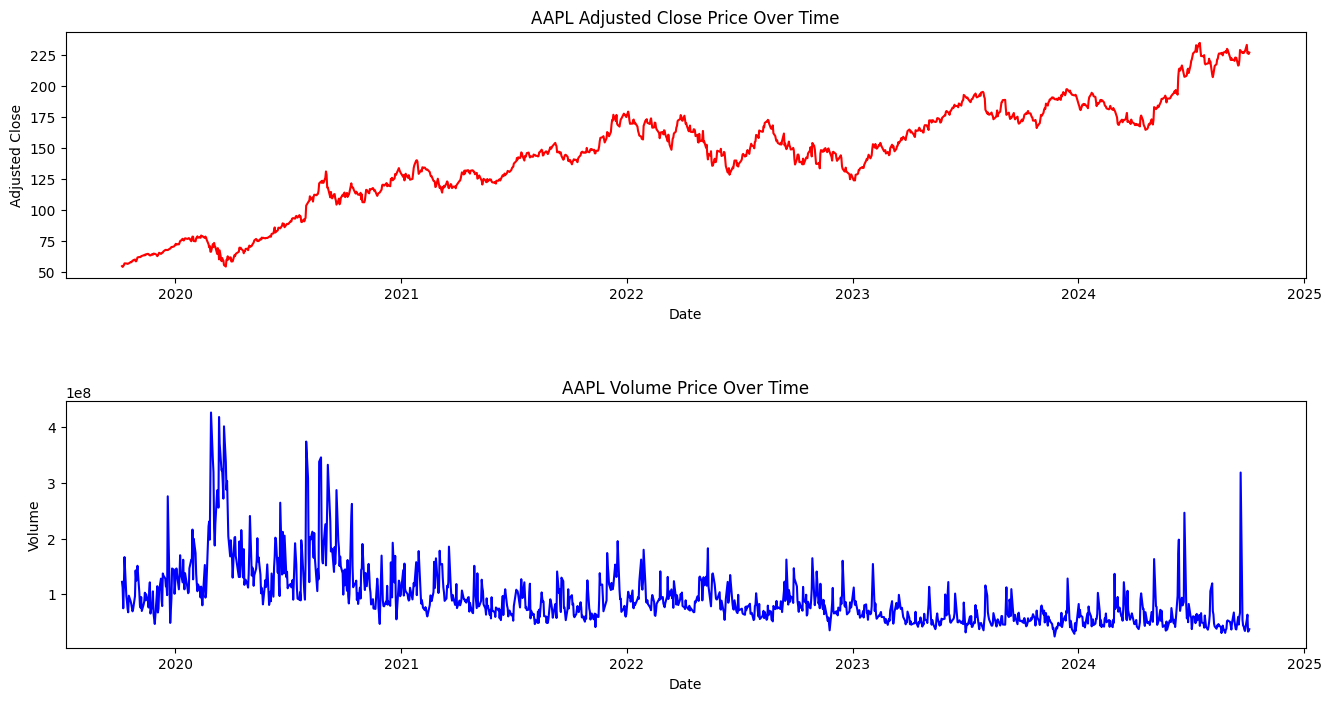

In [386]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

ax1.plot(df['Date'], df['Adj Close'], color='red')
ax2.plot(df['Date'], df['Volume'], color='blue')

ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close')
ax1.set_title('AAPL Adjusted Close Price Over Time')
ax2.set_xlabel('Date')

ax2.set_ylabel('Volume')
ax2.set_title('AAPL Volume Price Over Time')

plt.subplots_adjust(hspace=0.5)
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

Adjusted Close은 올라가는 추세 \
 Volume은 2020 ~ 2021년에 변동이 심하고, 그 이후로는 일정한 줄 알았는데 최근에 주기성을 보임.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

정상성 조건 \
1. $E(X_t) = \mu \quad \forall t$ \
2. $Var(X_t) = \sigma^2 \quad \forall t$ \
3. $Cov(X_t, X_{t-k}) = \rho(k) \quad \forall t$

정상성을 왜 해야하는가? \n$\quad$시계열 분석 방법론이 정상 시계열을 가정하고 개발되었기 때문에

비정상성 해결 방법 \
1. $차분 : Y_t = X_t - X_{t-k}$ \
2. $변환 : Y_t = \log(X_t)$


2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

(-0.5, 947.5, 609.5, -0.5)

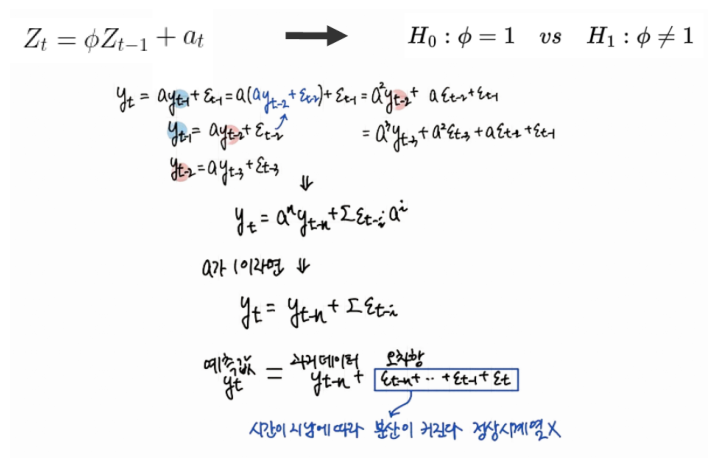

In [387]:
import matplotlib.image as mpimg

image_path = '/content/sample_data/화면 캡처 2024-10-05 022435.png'
img = mpimg.imread(image_path)

plt.figure(figsize=(9, 9))
plt.imshow(img)
plt.axis('off')

In [388]:
def adf_test(y):
    dftest = adfuller(y, autolag='AIC')
    output = pd.Series(dftest[0:2], index=['test statistic', 'p-value'])
    print(output)

In [389]:
adf_test(df['Adj Close'])

test statistic   -1.258161
p-value           0.648090
dtype: float64


2.3 ADF Test 결과를 해석하세요.

유의수준 5%에서 p-value = 0.63으로 귀무가설을 기각하지 못한다. 즉, 단위근이 1이므로 비정상 시계열이다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

ACF (Autocorrelation Function) : 자기상관함수

> ACF의 감소속도로 시계열의 정상성을 판단할 수 있다. \n정상 시계열인 경우에는 시점이 멀어질수록 ACF가 빠르게 감소하게 된다. \n비정상 시계열인 경우에는 시점 간에 영향을 주고 받아서 ACF의 감소속도가 느리다.


$ACF(k) = \frac{COV(Y_t, Y_{t-k})}{VAR(Y_t)}$


PACF (Partial Autocorrelation Function) : 부분자기상관함수




> $Y_t$ 와  $Y_{t-k}$ 의 순수한 상관관계를 계수로 나타낸 것. \n상관관계가 있다고 판단되면, 모형에 들어간다.




$PACF(k) = Corr(Y_t, Y_{t-k}\space|\space Y_1,\space Y_2,\space Y_3,\space...\space,\space Y_{t-(k-1)})$


2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

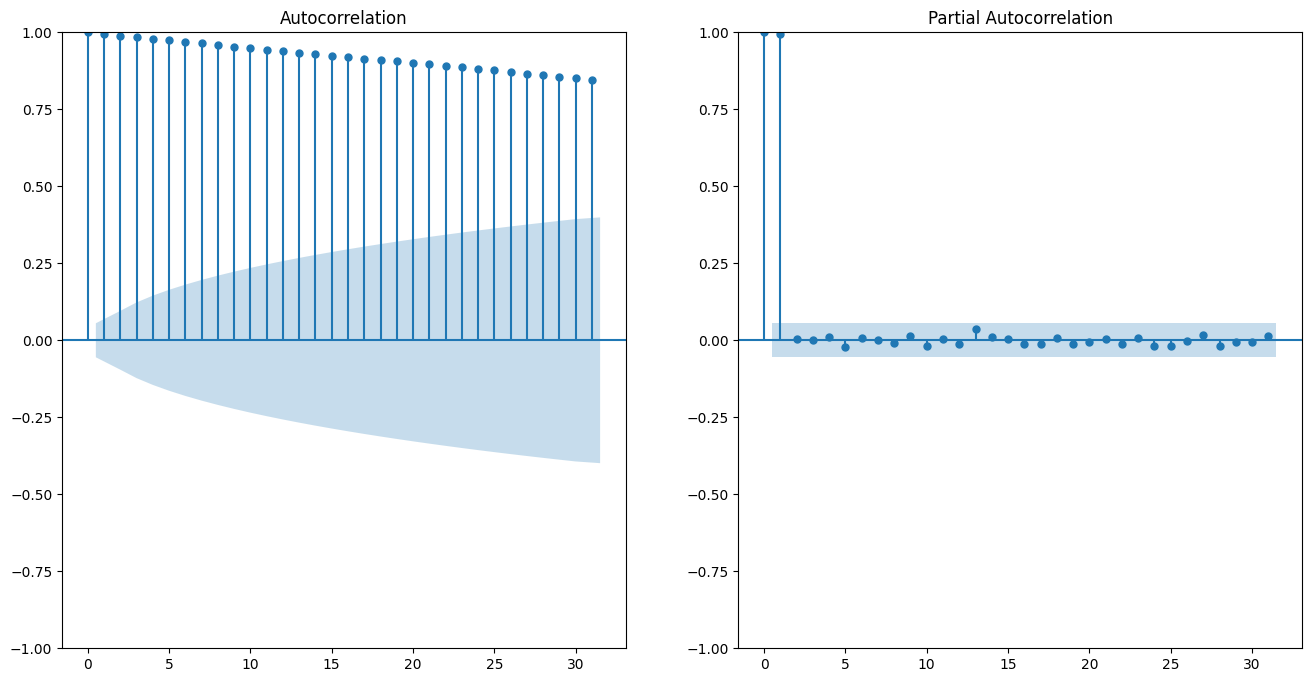

In [390]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plot_acf(df['Adj Close'], ax=ax1)
plot_pacf(df['Adj Close'], method='ywm', ax=ax2)
plt.show()

2.6 결과를 해석하세요.

ACF : 천천히 감소하므로 비정상성이 의심된다. \
PACF : 0시점 = 자기 자신과의 자기상관 = 1로 해석한다.  2시점부터 PACF가 0에 근접한다.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

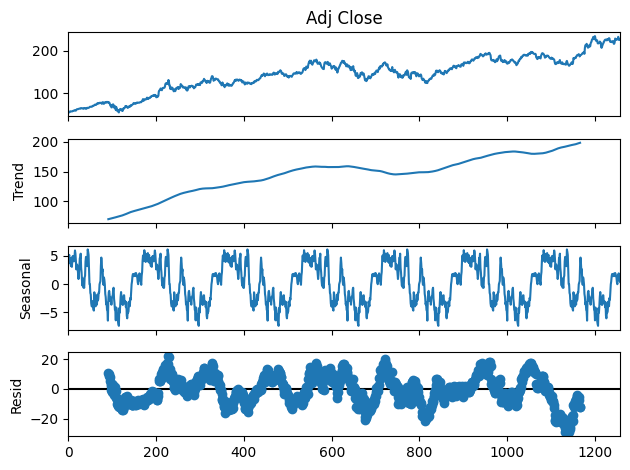

In [391]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

season = seasonal_decompose(df['Adj Close'], period = 182)

fig = season.plot()
plt.show()

2.8 위 결과를 해석하세요.

Trend = 추세 : 올라가는 추세 \
Seasonal = 계절성 : 6개월 주기가 보이므로, 계절성을 띤다고 할 수 있다. \
Resid = 잔차 : 잔차가 평균선 근처에서 많이 보일수록 데이터의 변동성(패턴)을 잘 포착한다. 지금 그래프만 봐선 잘 모름.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

$차분 : Y_t = X_t - X_{t-k}$ \
올라가거나 내려가는 추세가 보일 때, 차분을 통해 추세를 없앤다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [392]:
df['Adj Close Diff'] = df['Adj Close'].diff(1)
df2=df.dropna()

In [393]:
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close Diff
1,2019-10-08,56.455002,57.014999,56.082500,56.099998,54.284832,111820000,-0.643482
2,2019-10-09,56.757500,56.947498,56.410000,56.757500,54.921062,74770400,0.636230
3,2019-10-10,56.982498,57.610001,56.825001,57.522499,55.661301,113013600,0.740238
4,2019-10-11,58.237499,59.410000,58.077499,59.052502,57.141800,166795600,1.480499
5,2019-10-14,58.724998,59.532501,58.667500,58.967499,57.059547,96427600,-0.082253


In [394]:
adf_test(df2['Adj Close Diff'])

test statistic   -36.114408
p-value            0.000000
dtype: float64


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

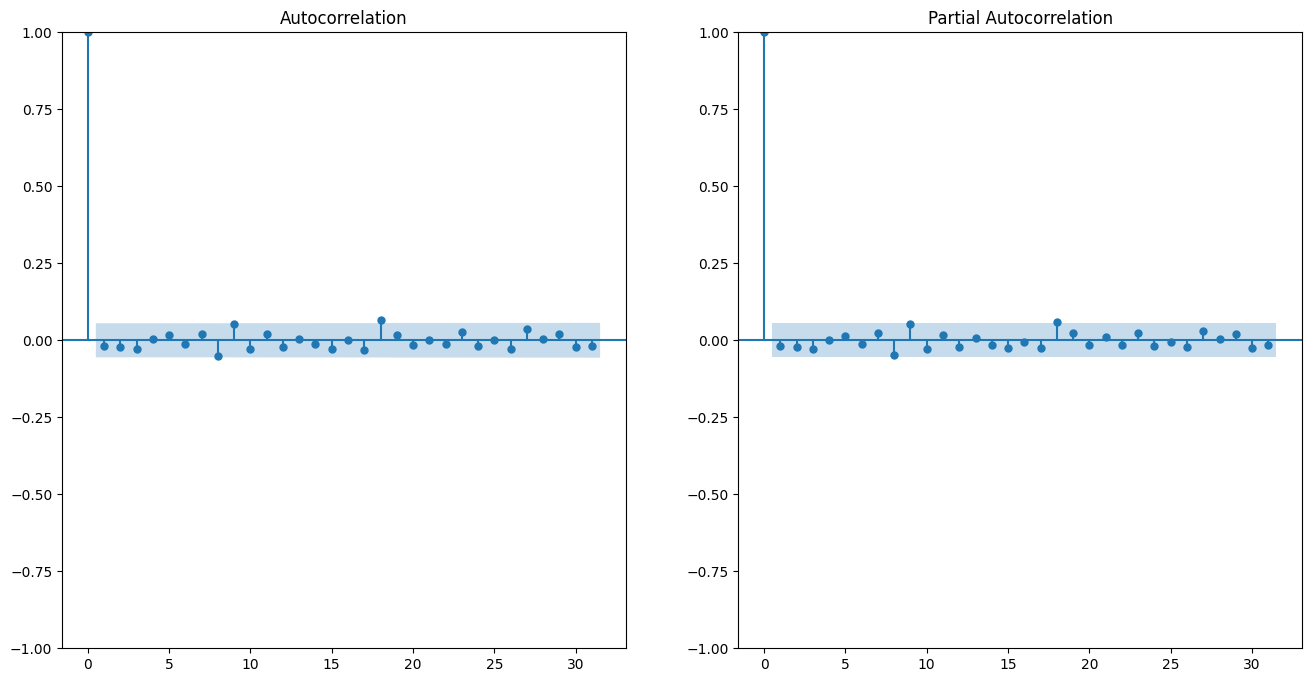

In [395]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plot_acf(df2['Adj Close Diff'], ax=ax1)
plot_pacf(df2['Adj Close Diff'], method='ywm', ax=ax2)
plt.show()

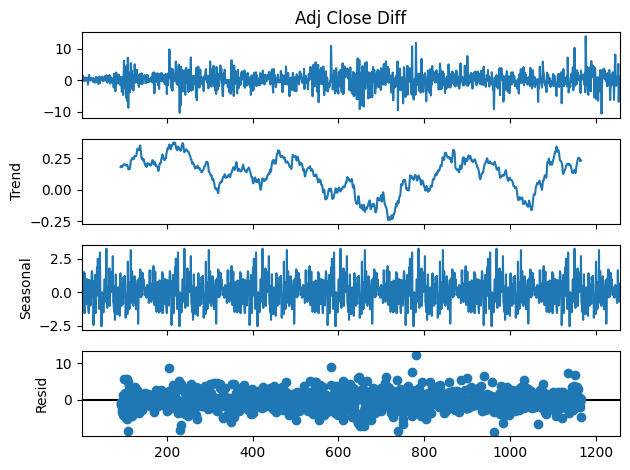

In [396]:
season = seasonal_decompose(df2['Adj Close Diff'], period = 182)

fig = season.plot()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [397]:
from statsmodels.tsa.arima.model import ARIMA

In [398]:
df['Adj Close Diff']

,Adj Close Diff
0,NaN
1,-0.643482
2,0.636230
3,0.740238
4,1.480499
...,...
1253,5.210007
1254,-6.789993
1255,0.569992
1256,-1.110001


In [399]:
model = ARIMA(df['Adj Close Diff'], order=(3, 0, 0))  #위에서 차분을 미리 했으므로 차분 값은 0으로 설정
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Adj Close Diff   No. Observations:                 1258
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2989.968
Date:                Sat, 05 Oct 2024   AIC                           5989.936
Time:                        06:04:47   BIC                           6015.623
Sample:                             0   HQIC                          5999.590
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1367      0.070      1.966      0.049       0.000       0.273
ar.L1         -0.0206      0.024     -0.877      0.381      -0.067       0.025
ar.L2         -0.0213      0.026     -0.831      0.406      -0.071       0.029
ar.L3         -0.0283      0.027     -1.069      0.285      -0.080       0.024
sigma2         6.8171      0.190     35.795      0.000       6.444       7.190
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               278.44
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.01
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

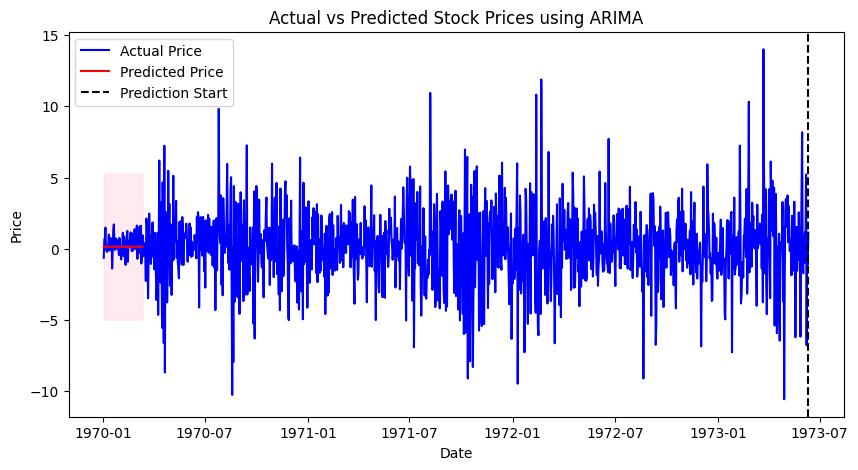

In [400]:
#예측 수행(50일, 200일해도 달라지지 않았음 ㅠ)
forecast_result = model_fit.get_forecast(steps=50)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# 예측 수행 및 시각화
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Adj Close Diff'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=df.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [401]:
#실제 데이터 가져오기
actual_data_last_50 = yf.download(stock, start='2024-01-01', end='2024-03-01')
actual_last_50 = actual_data_last_50[['Close']]


[*********************100%***********************]  1 of 1 completed


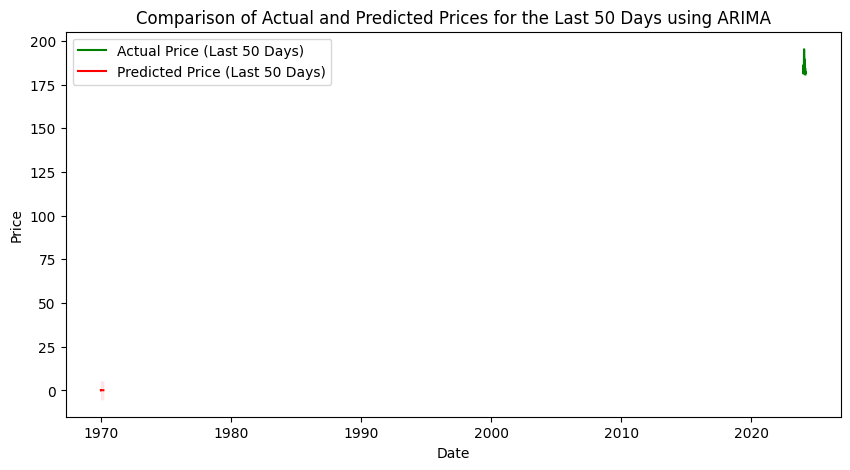

In [402]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [403]:
from prophet import Prophet

In [404]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'AAPL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%***********************]  1 of 1 completed


In [405]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3p07utn8/g2682zbk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3p07utn8/r2b5450x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68518', 'data', 'file=/tmp/tmp3p07utn8/g2682zbk.json', 'init=/tmp/tmp3p07utn8/r2b5450x.json', 'output', 'file=/tmp/tmp3p07utn8/prophet_modelqy7o9fsg/prophet_model-20241005060448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:04:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:04:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [406]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


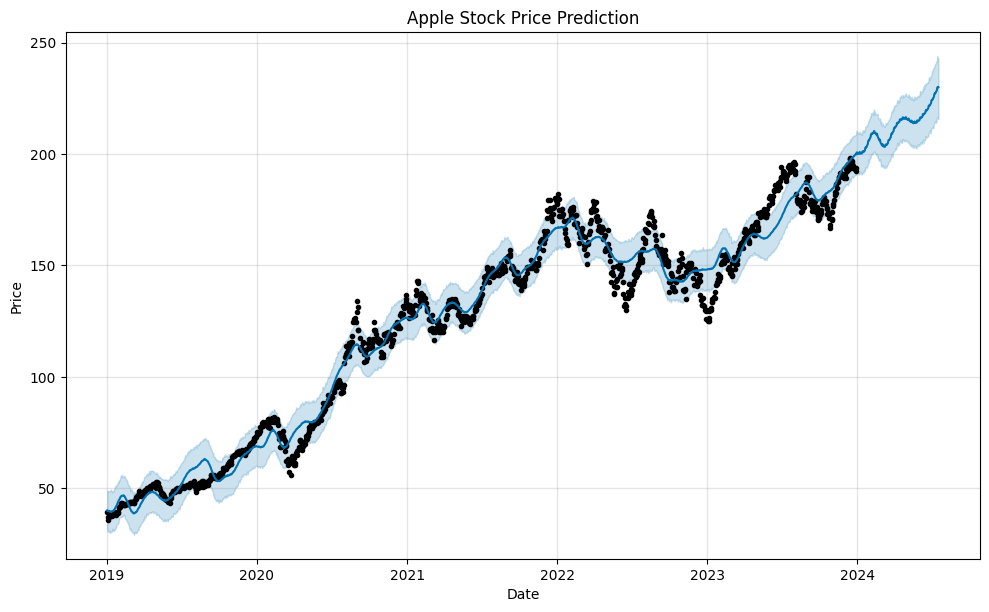

In [407]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

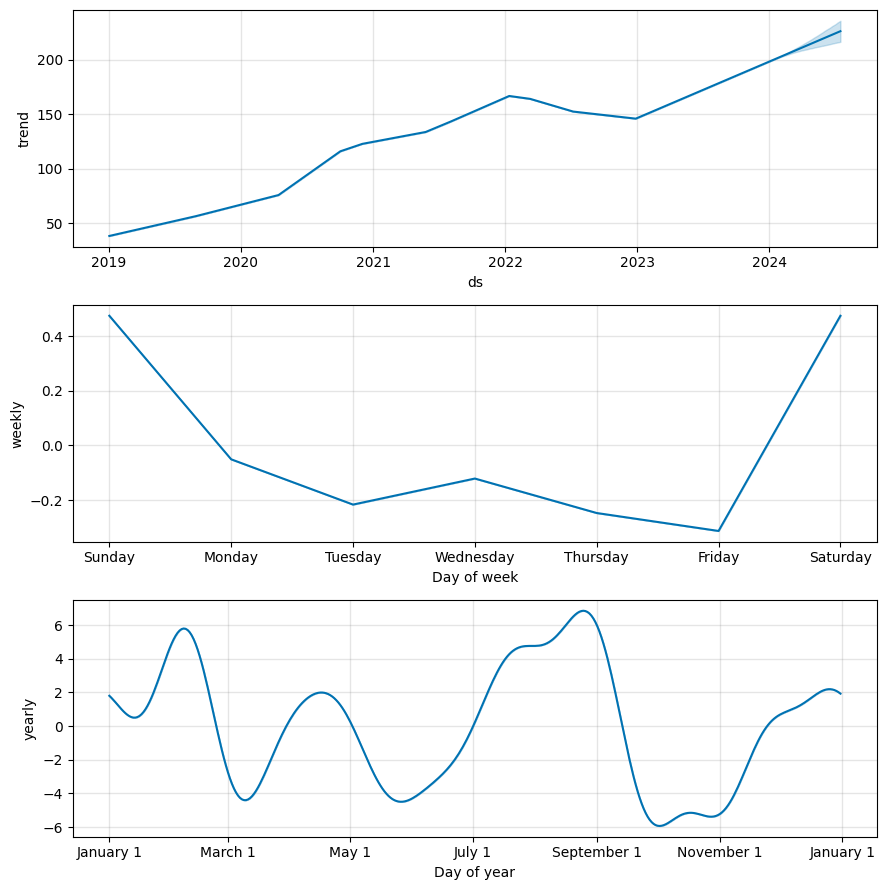

In [408]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [409]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%***********************]  1 of 1 completed


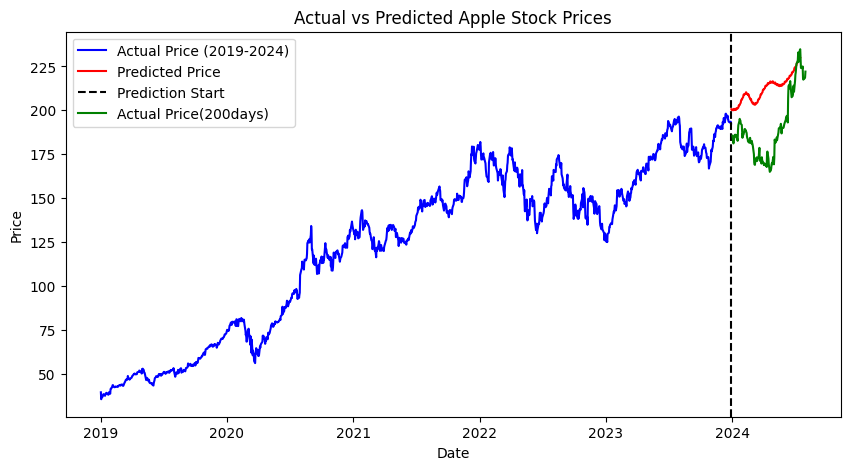

In [410]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다.

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다.

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.

# 자유 분석 : LSTM

### 데이터 불러오기


In [416]:
stock = '035420.KS' # 네이버 주식

df = yf.download(stock, start='2021-09-30', end='2024-09-30')

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-30,383000.0,390000.0,381000.0,388000.0,383440.93750,611128
2021-10-01,388500.0,389500.0,381500.0,382000.0,377511.43750,402239
2021-10-05,378500.0,380000.0,370000.0,370500.0,366146.53125,828794
2021-10-06,373000.0,383500.0,371500.0,373000.0,368617.21875,826716
2021-10-07,380500.0,394000.0,378000.0,393500.0,388876.34375,832068


In [412]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [413]:
df.reset_index(inplace=True)

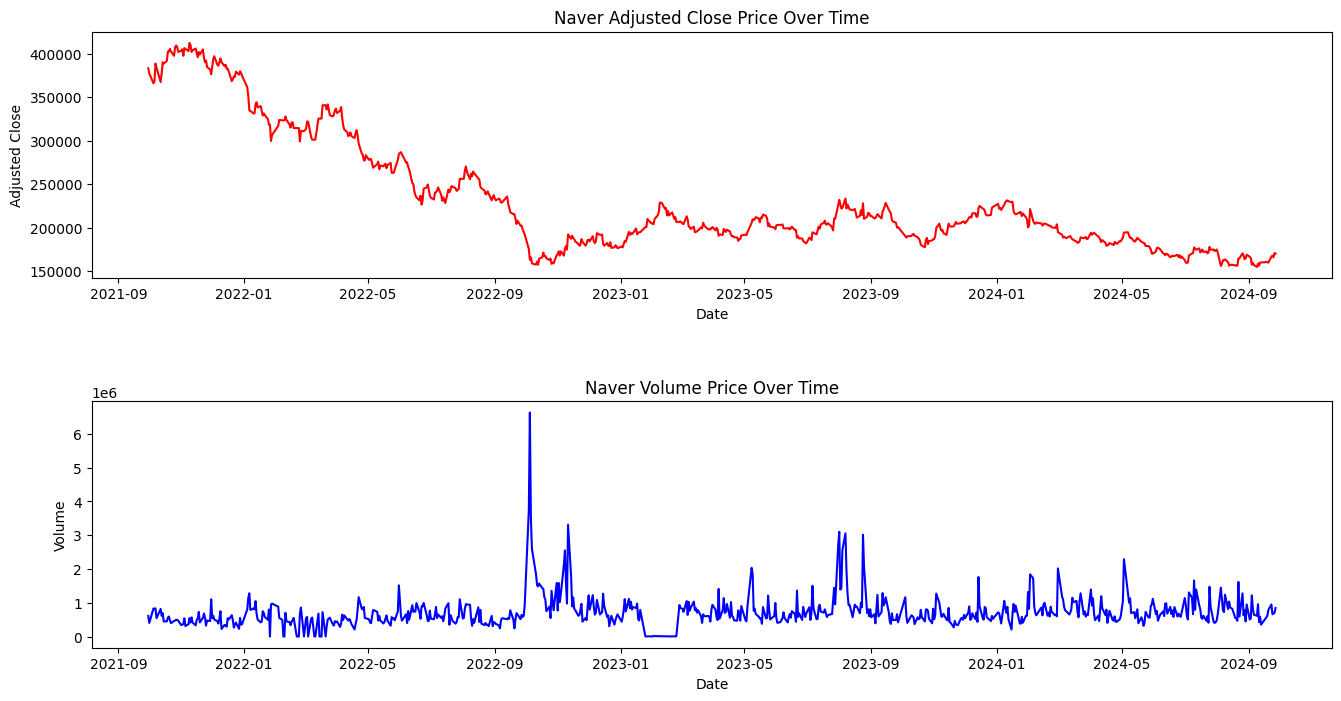

In [414]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

ax1.plot(df['Date'], df['Adj Close'], color='red')
ax2.plot(df['Date'], df['Volume'], color='blue')

ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close')
ax1.set_title('Naver Adjusted Close Price Over Time')
ax2.set_xlabel('Date')

ax2.set_ylabel('Volume')
ax2.set_title('Naver Volume Price Over Time')

plt.subplots_adjust(hspace=0.5)
plt.show()

### 데이터셋 분리

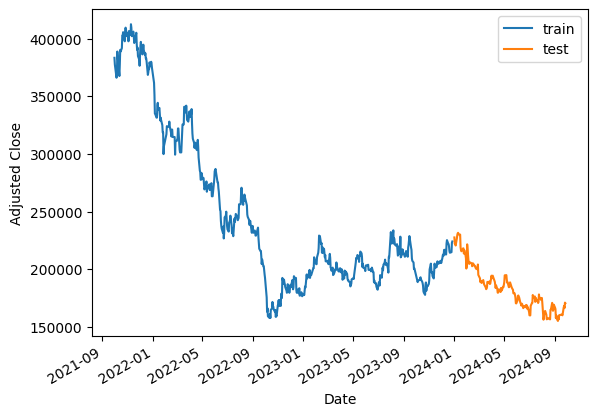

In [417]:
import pandas as pd
import matplotlib.pyplot as plt

# Adj Close 열만 빼기, split 기준은 2024년 1월 1일
data = df[['Adj Close']]
split = pd.Timestamp('01-01-2024')

# 시점 분리
train = pd.DataFrame(data.loc[:split, ['Adj Close']])
test = pd.DataFrame(data.loc[split:, ['Adj Close']])

# 시각화
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.show()

### 훈련, 테스트 데이터셋 생성

In [418]:
from sklearn.preprocessing import MinMaxScaler

# 정규화 (0 ~ 1)
scaler = MinMaxScaler()
train_sc = scaler.fit_transform(train)
test_sc= scaler.transform(test)

In [419]:
# To DataFrame
train_sc_df = pd.DataFrame(train_sc, columns=['Adj Close'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Adj Close'], index=test.index)

# 과거 데이터 7개로 예측
for i in range(1, 8):
    train_sc_df ['Adj Close_{}'.format(i)]=train_sc_df ['Adj Close'].shift(i)
    test_sc_df ['Adj Close_{}'.format(i)]=test_sc_df ['Adj Close'].shift(i)

In [420]:
# x, y 분리
x_train = train_sc_df.dropna().drop('Adj Close', axis=1)
y_train = train_sc_df.dropna()[['Adj Close']]

x_test = test_sc_df.dropna().drop('Adj Close', axis=1)
y_test = test_sc_df.dropna()[['Adj Close']]

In [421]:
x_train.head()

,Adj Close_1,Adj Close_2,Adj Close_3,Adj Close_4,Adj Close_5,Adj Close_6,Adj Close_7
Date,,,,,,,
2021-10-13,0.823686,0.887624,0.906999,0.827561,0.817873,0.862436,0.885686
2021-10-14,0.862436,0.823686,0.887624,0.906999,0.827561,0.817873,0.862436
2021-10-15,0.912812,0.862436,0.823686,0.887624,0.906999,0.827561,0.817873
2021-10-18,0.906999,0.912812,0.862436,0.823686,0.887624,0.906999,0.827561
2021-10-19,0.918624,0.906999,0.912812,0.862436,0.823686,0.887624,0.906999


In [422]:
y_train.head()

,Adj Close
Date,
2021-10-13,0.862436
2021-10-14,0.912812
2021-10-15,0.906999
2021-10-18,0.918624
2021-10-19,0.961250


In [423]:
# Array로 변환
x_train = x_train.values
x_test = x_test.values

y_train = y_train.values
y_test = y_test.values

In [424]:
# (N , 7, 1) 텐서
x_train_t = x_train.reshape(x_train.shape[0], 7,1)
x_test_t = x_test.reshape(x_test.shape[0], 7, 1)

### 모델 훈련

In [445]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

# 세션 초기화
K.clear_session()
# Sequeatial Model
model = Sequential()
# LSTM
model.add(LSTM(42,return_sequences=False, input_shape=(7, 1)))
# 예측값 1개
model.add(Dense(1, activation='linear'))
# 손실함수 : MSE
# 옵티마이저 : adam
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 42)                  │           7,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              43 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,435 (29.04 KB)

 Trainable params: 7,435 (29.04 KB)

 Non-trainable params: 0 (0.00 B)

In [446]:
#epochs = 훈련 반복 횟수, batch_size = 한 번 훈련할 때 입력되는 데이터 크기
model.fit(x_train_t, y_train, epochs=50,
          batch_size=5, verbose=0)

y_pred = model.predict(x_test_t)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


### 예측 결과

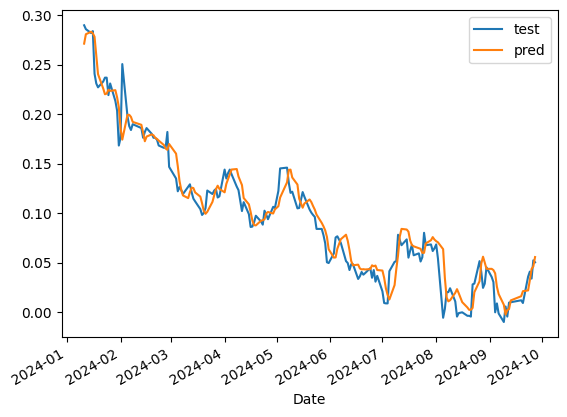

In [447]:
t_df = test_sc_df.dropna()
y_test_df = pd.DataFrame(y_test, columns=['Adj Close'], index=t_df.index)
y_pred_df = pd.DataFrame(y_pred, columns=['Adj Close'], index=t_df.index)

ax1=y_test_df.plot()
y_pred_df.plot(ax=ax1)
plt.legend(['test','pred'])

### 성능 확인

In [448]:
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

actual_y = y_test_df['Adj Close'].values
predicted_y = y_pred_df['Adj Close'].values

rmse = root_mean_squared_error(actual_y, predicted_y)
mae = mean_absolute_error(actual_y, predicted_y)
r_squared = r2_score(actual_y, predicted_y)

print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared :", r_squared)

MSE: 0.016069603944476048
MAE: 0.012038589135189588
R-squared : 0.9466643715858127


$RMSE = \frac{1}{n}\sum(y - \hat{y})^2$ \
\
$MAE = \frac{1}{n}\sum|y - \hat{y}|$ \
\
$R^2 = \frac{SSR}{SST} = \frac{\sum(\hat{y} - \bar{y})^2}{\sum(y - \bar{y})^2}$